# Miami Beach Temperatures Forecast - Time Series Analysis

The dataset contains 2,906,327 daily average temperature readings from 1995-2020 across a wide range of cities around the world. The data is from [Kaggle](https://www.kaggle.com/datasets/sudalairajkumar/daily-temperature-of-major-cities/code) and was compiled from various text files of temperature data from the University of Dayton website. The main objective of the analysis is to forecast future temperatures in Miami Beach using a variety of smoothing techniques for time series analysis. We will first clean and prepare the data in order to get a sense of the Miami Beach data. Then, we will decompose the time series data into trend, seasonality, and residual to illustrate how temperatures may be generally increasing over time, how much of an impact season has on monthly average temperatures, and how some years may have been susceptible to outlying temperatures. After, we will fit the monthly temperature data to each of the models in order to forecast future temperatures. Finally, we will evaluate the performance of each of the models by visually comparing the predictions to the test data as well as utilizing the mean squared error metric to evaluate each technique.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import mse
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import Holt
from statsmodels.tsa.api import ExponentialSmoothing

import warnings

warnings.filterwarnings("ignore")

## Data Preprocessing

In [2]:
# Make sure that each column contains uniform data types for each entry
city_temperatures_data = pd.read_csv('city_temperature.csv', dtype={'Region' : 'str', 
                                                                     'State' : 'str',
                                                                     'City' : 'str',
                                                                     'Month' : 'int',
                                                                     'Day' : 'int',
                                                                     'Year' : 'int',
                                                                     'AvgtTemperature' : 'float'})
                                                                     
city_temperatures_data.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


In [3]:
# Confirm number of rows and data types
city_temperatures_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906327 entries, 0 to 2906326
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Region          object 
 1   Country         object 
 2   State           object 
 3   City            object 
 4   Month           int32  
 5   Day             int32  
 6   Year            int32  
 7   AvgTemperature  float64
dtypes: float64(1), int32(3), object(4)
memory usage: 144.1+ MB


In [4]:
# Aggregate month, day, and year into one column to use as date objects for easier arrangement of values
city_temperatures_data['Date'] = pd.to_datetime(city_temperatures_data[['Year', 'Month', 'Day']], errors='coerce')
city_temperatures_data.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature,Date
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2,1995-01-01
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4,1995-01-02
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8,1995-01-03
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4,1995-01-04
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9,1995-01-05


In [5]:
# Locate only the data that contains daily average temperatures for Miami Beach
miami_temperatures_data = city_temperatures_data[city_temperatures_data['City'] == 'Miami Beach']
miami_temperatures_data = miami_temperatures_data[['Date', 'AvgTemperature']]
miami_temperatures_data.set_index('Date', inplace=True)                                                               ,
miami_temperatures_data

,AvgTemperature
Date,
1995-01-01,72.1
1995-01-02,72.9
1995-01-03,72.9
1995-01-04,71.8
1995-01-05,66.9
...,...
2020-05-09,78.1
2020-05-10,76.8
2020-05-11,76.0


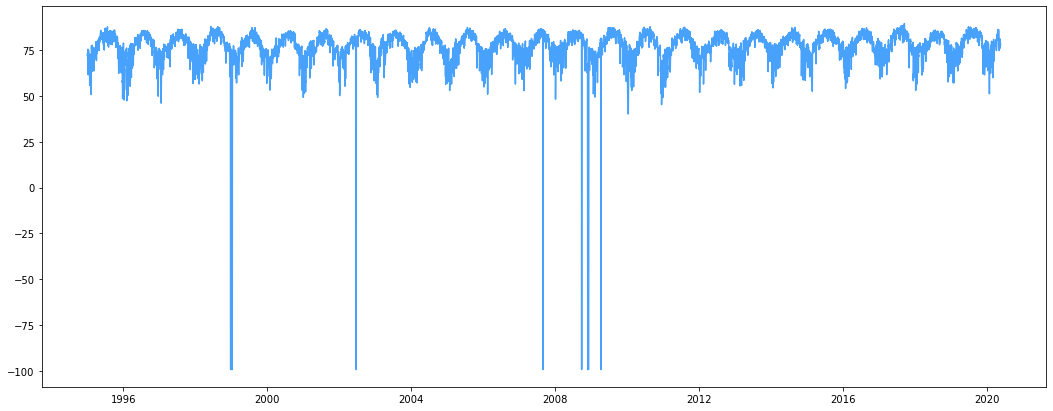

In [6]:
# Plot all daily average temperatures for Miami Beach from 1995-2020
fig, ax = plt.subplots(figsize=(18,7))
ax.plot(miami_temperatures_data, c='#48A1FA')
plt.show()

As seen by the graphic above, there seems to be some peculiar data that does not seem quite right. We must find these values in order to find a solution.

In [7]:
miami_temperatures_data[miami_temperatures_data['AvgTemperature'] < 25]

,AvgTemperature
Date,
1998-12-24,-99.0
1998-12-25,-99.0
1998-12-30,-99.0
1998-12-31,-99.0
1999-01-10,-99.0
2002-06-18,-99.0
2002-06-19,-99.0
2002-06-20,-99.0
2002-06-21,-99.0


In [8]:
miami_temperatures_data['AvgTemperature'].replace(-99, np.NAN, inplace=True)
miami_temperatures_data.isnull().sum()

AvgTemperature    23
dtype: int64

As seen in the above dataframe, there seems to be 23 daily average temperatures that indicate that some days reached -99 degrees Fahrenheit. This is likely not actually the case and was used to indicate missing data points. In order to proceed, we must impute the data using a viable method that would make sense under this circumstance. Since we only have 23 missing data points out of several thousand, we will impute the missing data by using the prior day's average temperature called back filling. That should alleviate this issue.

In [9]:
# Back fill all missing values
miami_temperatures_data.fillna(method='bfill', inplace=True)
miami_temperatures_data.isnull().sum()

AvgTemperature    0
dtype: int64

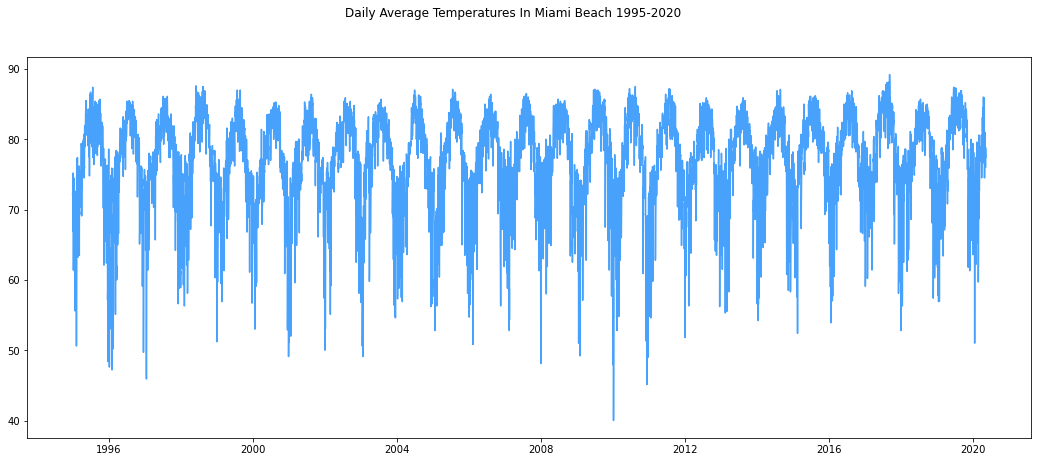

In [10]:
# Plot all daily average temperatures for Miami Beach from 1995-2020
fig, ax = plt.subplots(figsize=(18,7))
fig.suptitle("Daily Average Temperatures In Miami Beach 1995-2020")
ax.plot(miami_temperatures_data, c='#48A1FA')
plt.show()

Since daily average temperatures contain a lot of very similar data points that likely do not serve much of a purpose other than crowding the data, we will up sample the data to contain the monthly average temperatures instead of the daily average temperatures. This will make the visualization less crowded as well.

In [11]:
temp_daily = pd.Series(miami_temperatures_data['AvgTemperature'])
temp_monthly = temp_daily.resample('M').mean()
miami_monthly_temp = pd.DataFrame(temp_monthly)
miami_monthly_temp

,AvgTemperature
Date,
1995-01-31,66.948387
1995-02-28,67.710714
1995-03-31,72.983871
1995-04-30,76.756667
1995-05-31,81.951613
...,...
2020-01-31,71.309677
2020-02-29,72.741379
2020-03-31,76.332258


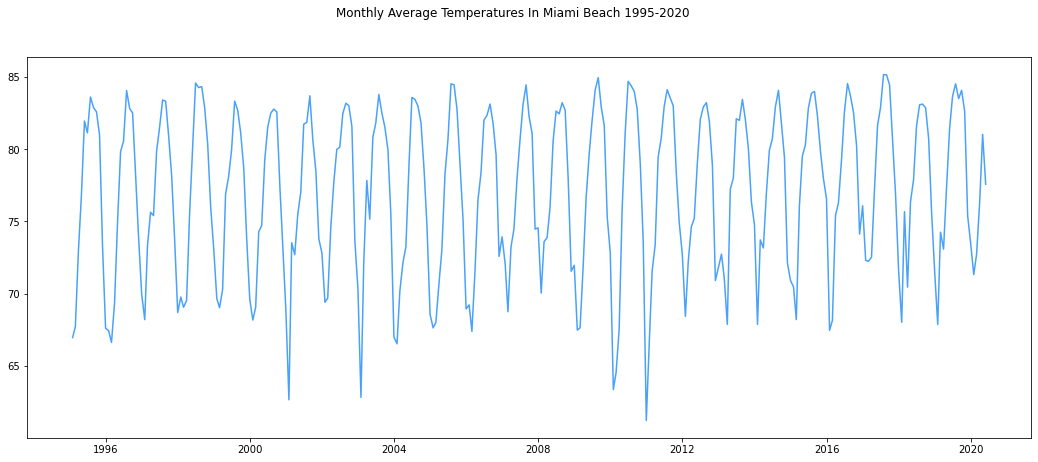

In [12]:
# Plot all monthly average temperatures for Miami Beach from 1995-2020
fig, ax = plt.subplots(figsize=(18,7))
fig.suptitle("Monthly Average Temperatures In Miami Beach 1995-2020")
ax.plot(miami_monthly_temp, c='#48A1FA')
plt.show()

## Time Series Decomposition

Now that the data is preprared for time series analysis, we will leverage additive decomposition in order to analyze the trend, seasonality, and residuals of the data. We will use additive decomposition as the magnitude of the seasonality appears to be independent of the data's general trend.

In [13]:
ss_decomposition = seasonal_decompose(x=miami_monthly_temp, model='additive', period=12)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

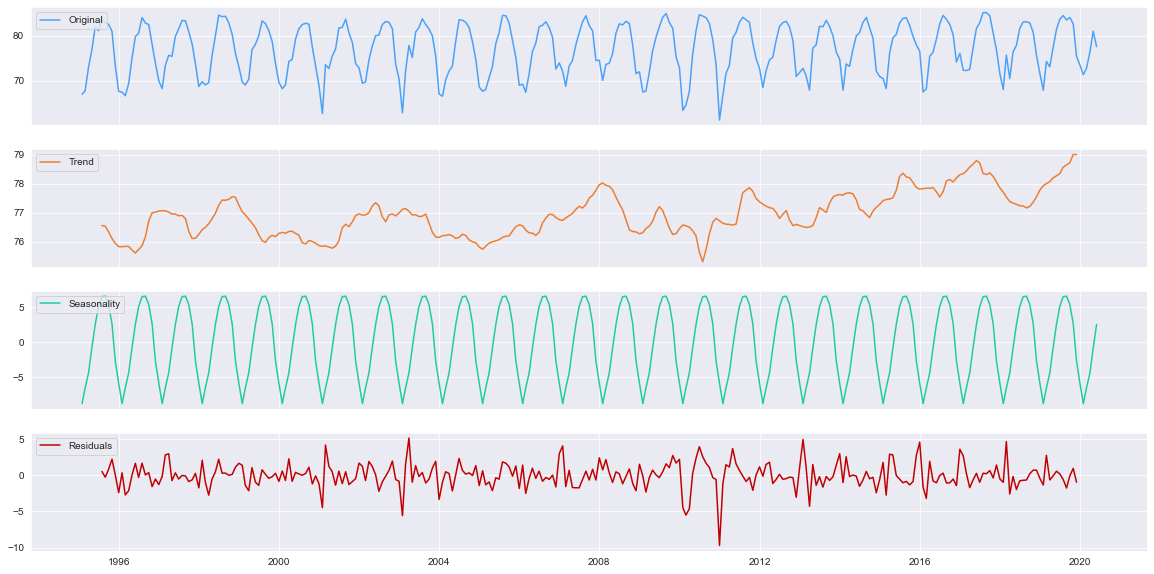

In [14]:
# Plot original, trend, seasonal, and residuals graphic
sns.set_style("darkgrid")
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(20,10))

axes[0].plot(miami_monthly_temp, label='Original', c="#48A1FA")
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend', c="#ED7D31")
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality', c="#1FCC9E")
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals', c="#C00000")
axes[3].legend(loc='upper left');

As seen above, the trend of the data seems to be somewhat increasing overtime, especially in recent years. The seasonality, as expected, is highly dependent on the months of the year which is no suprise as we are forecasting temperature data. The residuals are fairly consistent with the exception of some years which are obviously harder to explain.

The temperature data appears to be negatively skewed which can be in part be explained by Miami's particularly long summer seasons that have generally hot temperatures.

## Stationarity Test

Now we are going to check whether the data is stationary or not. We will first split the data into chunks in order to see how the mean and variance values change over time. We will then use a more proper testing metric in the form of the Dickey-Fuller test.

In [15]:
# Split the data into chunks
chunks = np.split(miami_monthly_temp['AvgTemperature'].values, 61)
    
chunks_df = pd.DataFrame({'Mean Values' : np.mean(chunks, axis=1), 'Variance Values' : np.var(chunks, axis=1)}, index=range(1, 62)) 
chunks_df.head(60)

,Mean Values,Variance Values
1,73.270250,31.695513
2,82.241398,1.047845
3,68.862951,5.795424
4,80.431892,10.004288
5,74.513828,27.596693
6,77.147419,9.208932
7,79.904194,13.265046
8,70.490899,6.287428
9,83.219204,2.922284
10,73.621657,17.549988


As seen from above, the data does seem to be a tad heteroscedastic as the variances are not very consistent. We will now use the augmented dickey-fuller test to test this as well. The more negative the ADF, the more confident we can be in rejecting the null hypothesis that the data is non-stationary. A lower p-value indicates that there would be a smaller area under the distribtuion curve, indicating that we would be more confident to again reject the null hypothesis that the data is non-stationary and that the data is actually stationary.

In [16]:
# define Dickey-Fuller Test (DFT) function
# Null is that unit root is present, rejection means likely stationary
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['ADF','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False);

ADF                      -2.735970
p-value                   0.068018
Lags Used                14.000000
Observations Used       290.000000
Critical Value (1%)      -3.453102
Critical Value (5%)      -2.871559
Critical Value (10%)     -2.572108
dtype: float64


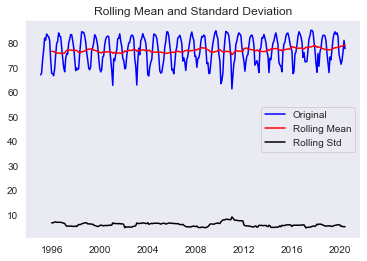

In [17]:
# run DFT on monthly
dftest(miami_monthly_temp['AvgTemperature'])
# p-value allows us to reject a unit root: data is stationary

Given that the ADF is fairly negative and that the p-value is close to zero, we can reject the null hypothesis that the data is non-stationary and that the data is actually stationary.

## Forecasting By Smoothing Techniques

In [18]:
# Split into train and test data
train = np.array(miami_monthly_temp['AvgTemperature'][:230])
test = np.array(miami_monthly_temp['AvgTemperature'][230:])

### Simple Average Smoothing

In [19]:
# find mean of series
trend_seasonal_avg = np.mean(miami_monthly_temp['AvgTemperature'])

# create array of mean value equal to length of time array
simple_avg_preds = np.full(shape=len(test), fill_value=trend_seasonal_avg, dtype='float')

# Mean Squared Error
simple_mse = mse(test, simple_avg_preds)

# Results
print("Predictions: ", simple_avg_preds)
print("MSE: ", simple_mse)

Predictions:  [76.9233022 76.9233022 76.9233022 76.9233022 76.9233022 76.9233022
 76.9233022 76.9233022 76.9233022 76.9233022 76.9233022 76.9233022
 76.9233022 76.9233022 76.9233022 76.9233022 76.9233022 76.9233022
 76.9233022 76.9233022 76.9233022 76.9233022 76.9233022 76.9233022
 76.9233022 76.9233022 76.9233022 76.9233022 76.9233022 76.9233022
 76.9233022 76.9233022 76.9233022 76.9233022 76.9233022 76.9233022
 76.9233022 76.9233022 76.9233022 76.9233022 76.9233022 76.9233022
 76.9233022 76.9233022 76.9233022 76.9233022 76.9233022 76.9233022
 76.9233022 76.9233022 76.9233022 76.9233022 76.9233022 76.9233022
 76.9233022 76.9233022 76.9233022 76.9233022 76.9233022 76.9233022
 76.9233022 76.9233022 76.9233022 76.9233022 76.9233022 76.9233022
 76.9233022 76.9233022 76.9233022 76.9233022 76.9233022 76.9233022
 76.9233022 76.9233022 76.9233022]
MSE:  26.390703675870867


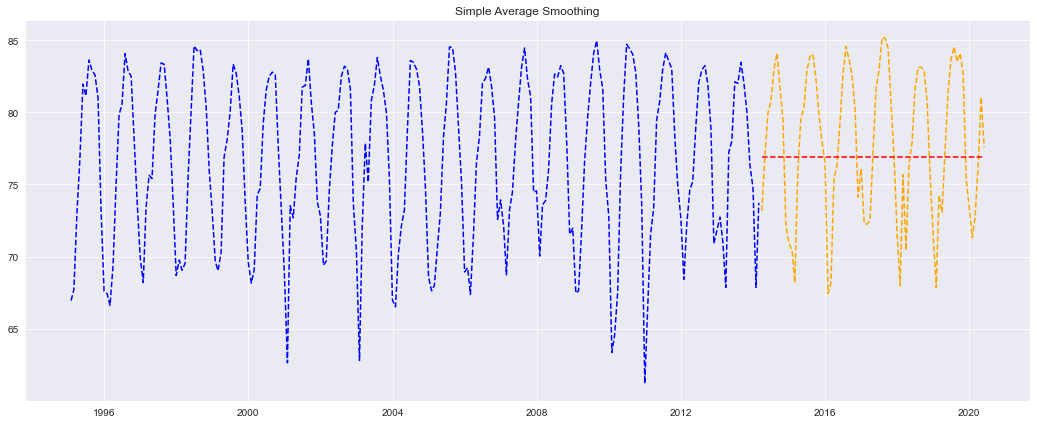

In [20]:
fig, ax = plt.subplots(figsize=(18,7))
ax.plot(miami_monthly_temp.index[:230], train, 'b--', label="train")
ax.plot(miami_monthly_temp.index[230:], test, color='orange', linestyle="--", label="test")
ax.plot(miami_monthly_temp.index[230:], simple_avg_preds, 'r--', label="predictions")
ax.set_title("Simple Average Smoothing");

### Single Exponential Smoothing

In [21]:
single = SimpleExpSmoothing(train).fit(optimized=True)
single_preds = np.round(single.forecast(len(test)), 3)
single_mse = mse(test, single_preds)

print("Predictions: ", single_preds)
print("MSE: ", single_mse)

Predictions:  [73.718 73.718 73.718 73.718 73.718 73.718 73.718 73.718 73.718 73.718
 73.718 73.718 73.718 73.718 73.718 73.718 73.718 73.718 73.718 73.718
 73.718 73.718 73.718 73.718 73.718 73.718 73.718 73.718 73.718 73.718
 73.718 73.718 73.718 73.718 73.718 73.718 73.718 73.718 73.718 73.718
 73.718 73.718 73.718 73.718 73.718 73.718 73.718 73.718 73.718 73.718
 73.718 73.718 73.718 73.718 73.718 73.718 73.718 73.718 73.718 73.718
 73.718 73.718 73.718 73.718 73.718 73.718 73.718 73.718 73.718 73.718
 73.718 73.718 73.718 73.718 73.718]
MSE:  43.01290785310203


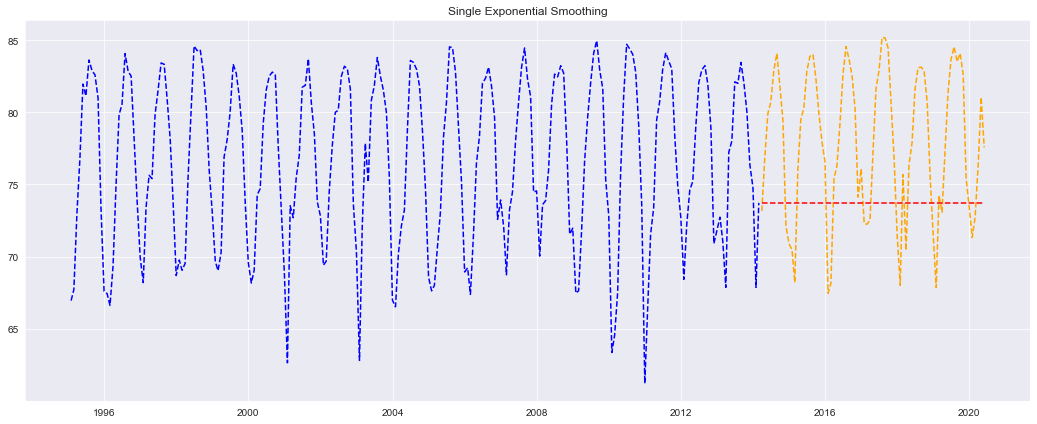

In [22]:
fig, ax = plt.subplots(figsize=(18,7))
ax.plot(miami_monthly_temp.index[:230], train, 'b--', label="train")
ax.plot(miami_monthly_temp.index[230:], test, color='orange', linestyle="--", label="test")
ax.plot(miami_monthly_temp.index[230:], single_preds, 'r--', label="predictions")
ax.set_title("Single Exponential Smoothing");

### Double Exponential Smoothing (Holt)

In [23]:
double = Holt(train).fit(optimized=True)
double_preds = double.forecast(len(test))
double_mse = mse(test, double_preds)
print("Predictions: ", double_preds)
print("MSE: ", double_mse)

Predictions:  [73.74741194 73.77696856 73.80652518 73.8360818  73.86563842 73.89519504
 73.92475166 73.95430827 73.98386489 74.01342151 74.04297813 74.07253475
 74.10209137 74.13164799 74.16120461 74.19076123 74.22031784 74.24987446
 74.27943108 74.3089877  74.33854432 74.36810094 74.39765756 74.42721418
 74.4567708  74.48632742 74.51588403 74.54544065 74.57499727 74.60455389
 74.63411051 74.66366713 74.69322375 74.72278037 74.75233699 74.7818936
 74.81145022 74.84100684 74.87056346 74.90012008 74.9296767  74.95923332
 74.98878994 75.01834656 75.04790318 75.07745979 75.10701641 75.13657303
 75.16612965 75.19568627 75.22524289 75.25479951 75.28435613 75.31391275
 75.34346936 75.37302598 75.4025826  75.43213922 75.46169584 75.49125246
 75.52080908 75.5503657  75.57992232 75.60947894 75.63903555 75.66859217
 75.69814879 75.72770541 75.75726203 75.78681865 75.81637527 75.84593189
 75.87548851 75.90504512 75.93460174]
MSE:  35.297262440179985


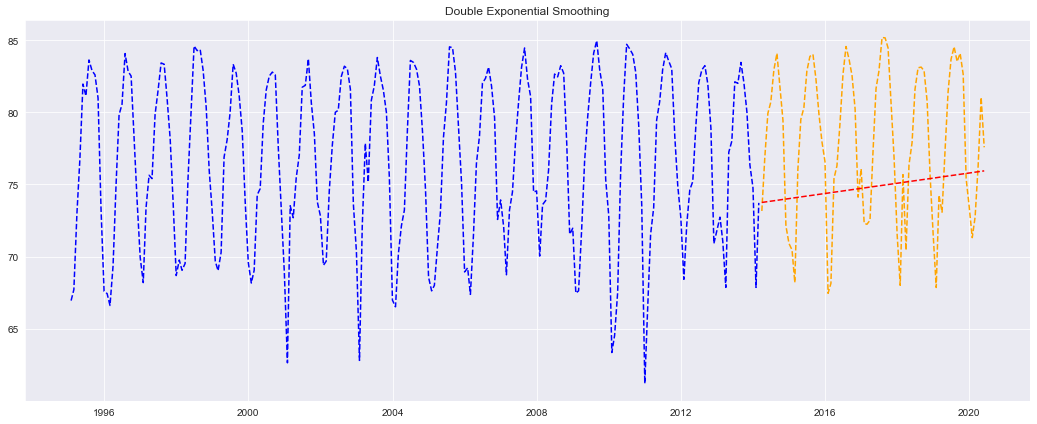

In [24]:
fig, ax = plt.subplots(figsize=(18,7))
ax.plot(miami_monthly_temp.index[:230], train, 'b--', label="train")
ax.plot(miami_monthly_temp.index[230:], test, color='orange', linestyle="--", label="test")
ax.plot(miami_monthly_temp.index[230:], double_preds, 'r--', label="predictions")
ax.set_title("Double Exponential Smoothing");

### Triple Exponential Smoothing

In [25]:
triple = ExponentialSmoothing(train,
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=12).fit(optimized=True)
triple_preds = triple.forecast(len(test))
triple_mse = mse(test, triple_preds)
print("Predictions: ", triple_preds)
print("MSE: ", triple_mse)

Predictions:  [72.64968175 76.1267846  79.78550647 82.25573172 83.6493424  83.80333267
 82.55415391 79.69705175 74.35380302 70.82812151 68.21562025 70.29727423
 72.68439533 76.16149817 79.82022005 82.2904453  83.68405598 83.83804625
 82.58886748 79.73176533 74.38851659 70.86283509 68.25033383 70.33198781
 72.7191089  76.19621175 79.85493362 82.32515887 83.71876956 83.87275983
 82.62358106 79.7664789  74.42323017 70.89754866 68.28504741 70.36670138
 72.75382248 76.23092532 79.8896472  82.35987245 83.75348313 83.9074734
 82.65829464 79.80119248 74.45794374 70.93226224 68.31976098 70.40141496
 72.78853606 76.2656389  79.92436078 82.39458603 83.78819671 83.94218698
 82.69300821 79.83590606 74.49265732 70.96697582 68.35447456 70.43612853
 72.82324963 76.30035248 79.95907435 82.4292996  83.82291028 83.97690055
 82.72772179 79.87061963 74.5273709  71.00168939 68.38918814 70.47084211
 72.85796321 76.33506605 79.99378793]
MSE:  3.962554860205123


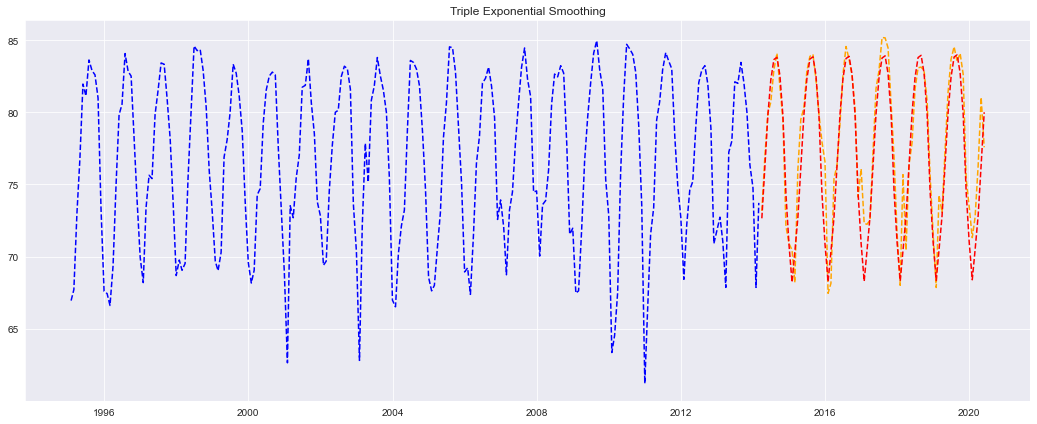

In [26]:
fig, ax = plt.subplots(figsize=(18,7))
ax.plot(miami_monthly_temp.index[:230], train, 'b--', label="train")
ax.plot(miami_monthly_temp.index[230:], test, color='orange', linestyle="--", label="test")
ax.plot(miami_monthly_temp.index[230:], triple_preds, 'r--', label="predictions")
ax.set_title("Triple Exponential Smoothing");

In [27]:
mse_df = pd.DataFrame(index=['Simple Average', 'Single Exponential', 'Double Exponential', 'Triple Exponential'], columns=['Mean Squared Error'], data=[simple_mse, single_mse, double_mse, triple_mse])
mse_df

,Mean Squared Error
Simple Average,26.390704
Single Exponential,43.012908
Double Exponential,35.297262
Triple Exponential,3.962555


## Conclusion/Next Steps

Given the results above, the triple exponential smoothing model by far performs the best as visually the predictions appear closest to the test data and the mean squared error is much lower than the other smoothing techniques. This is to be expected as the triple exponential smoothing model deals with seasonality the best as the technique contains the three smoothing equations of the stationarity component, trend component, and seasonal component. Given the fact that we are using temperature time series data, temperatures are very season dependent. Given that Miami is in the northern hemisphere, cooler temperatures are expected in the winter months and warmer temperatures are expected in the summer months. The next step would be to normalize the data further by possibly using a log transformation in order to receive an even more reliable result. Another step would be to use another type of time series model other than the smoothing techniques to possibly improve the model performance.